<a href="https://colab.research.google.com/github/joaofranca13/ml-experiments/blob/main/churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 6.9 MB/s 


In [186]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mutual_info_score, accuracy_score, precision_score, recall_score
from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


%matplotlib inline

## Loading Data

In [68]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [69]:
!wget $data

--2022-08-24 16:57:48--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘WA_Fn-UseC_-Telco-Customer-Churn.csv.1’

WA_Fn-UseC_-Telco-C 100%[===================>] 954.59K  --.-KB/s    in 0.03s   

2022-08-24 16:57:49 (31.2 MB/s) - ‘WA_Fn-UseC_-Telco-Customer-Churn.csv.1’ saved [977501/977501]



In [70]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Data Preparation

In [71]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [72]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

text_cols = list(df.dtypes[df.dtypes == "object"].index)

for col in text_cols:
  df[col] = df[col].str.lower().str.replace(' ', '_')


df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [73]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [74]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce').fillna(0)
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                object
dtype: object

In [75]:
df['churn'] = (df['churn'] == 'yes').astype(int)
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

## Validation Framework

In [76]:
df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=0), [int(.6*len(df)), int(.8*len(df))])

In [77]:
df_train, df_validate, df_test = df_train.reset_index(drop=True), df_validate.reset_index(drop=True), df_test.reset_index(drop=True)

In [78]:
print("Full Dataframe: " + str(round(df.shape[0]/df.shape[0], 4)))
print("Train Dataframe: " + str(round(df_train.shape[0]/df.shape[0], 4)))
print("Validation Dataframe: " + str(round(df_validate.shape[0]/df.shape[0], 4)))
print("Test Dataframe: " + str(round(df_test.shape[0]/df.shape[0], 4)))
print("Check (Must be 0): " + str(df.shape[0] - df_train.shape[0] - df_validate.shape[0] - df_test.shape[0]))

Full Dataframe: 1.0
Train Dataframe: 0.5999
Validation Dataframe: 0.2001
Test Dataframe: 0.2001
Check (Must be 0): 0


## EDA

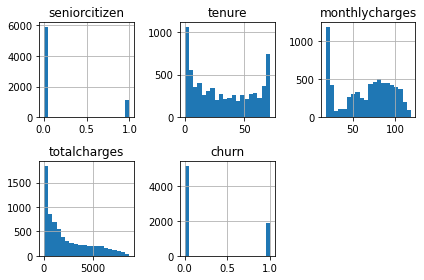

In [80]:
numerical = list(df_train.dtypes[df.dtypes != "object"].index)
df[numerical].hist(bins=20, layout=(2, 3))

plt.tight_layout()
plt.show()

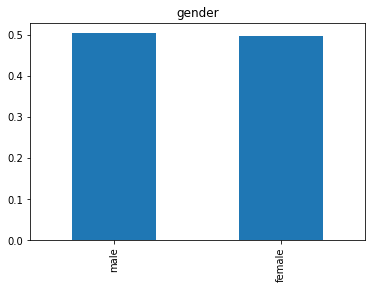

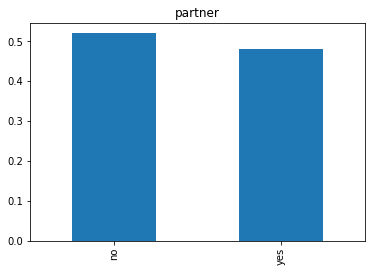

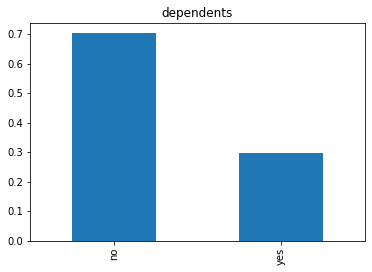

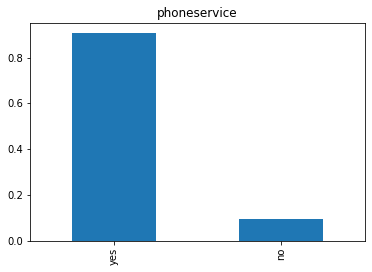

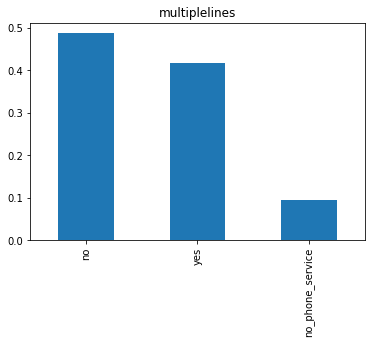

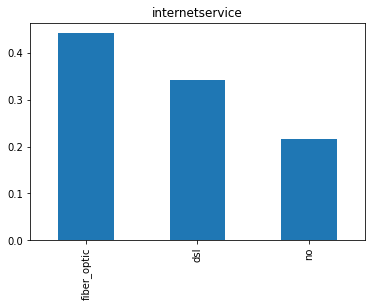

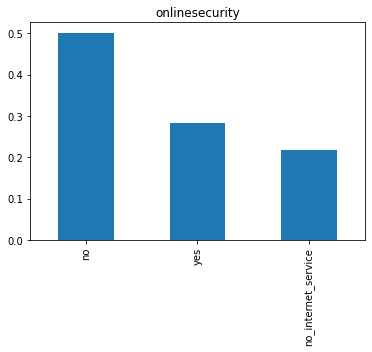

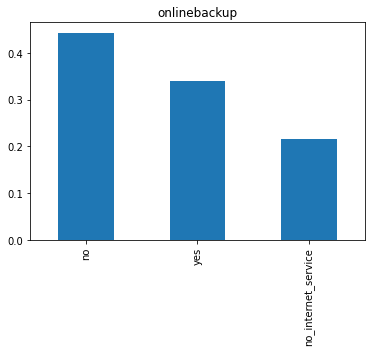

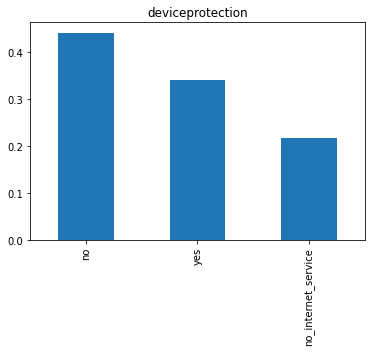

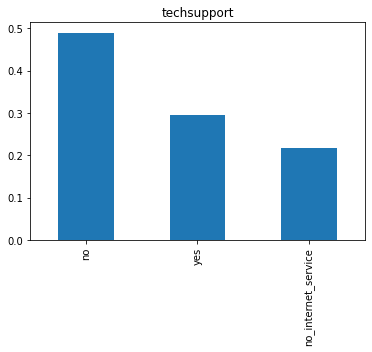

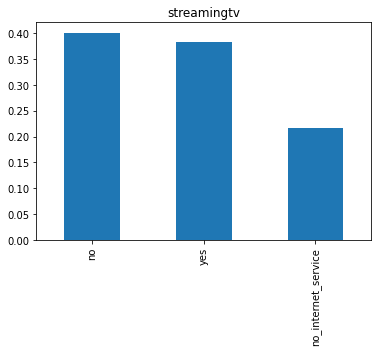

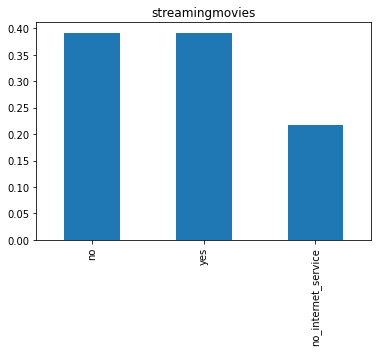

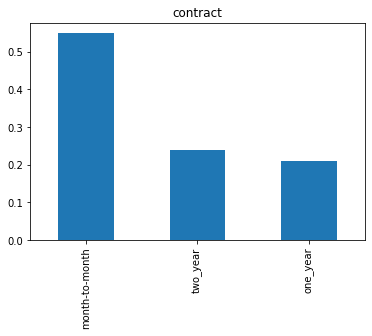

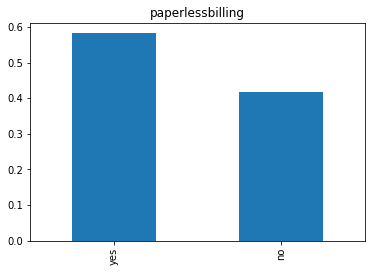

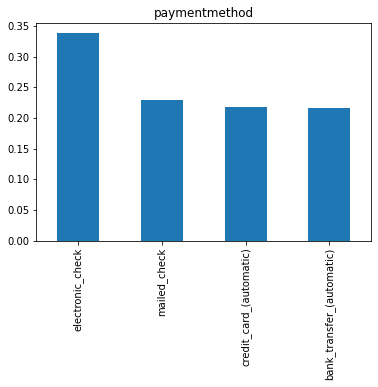

In [92]:
categorical = list(df_train.dtypes[(df_train.dtypes == "object")].index)
categorical.remove('customerid')

for var in categorical:
  df_train[var].value_counts(normalize=True).plot(kind='bar')
  plt.title(var)
  plt.show() 

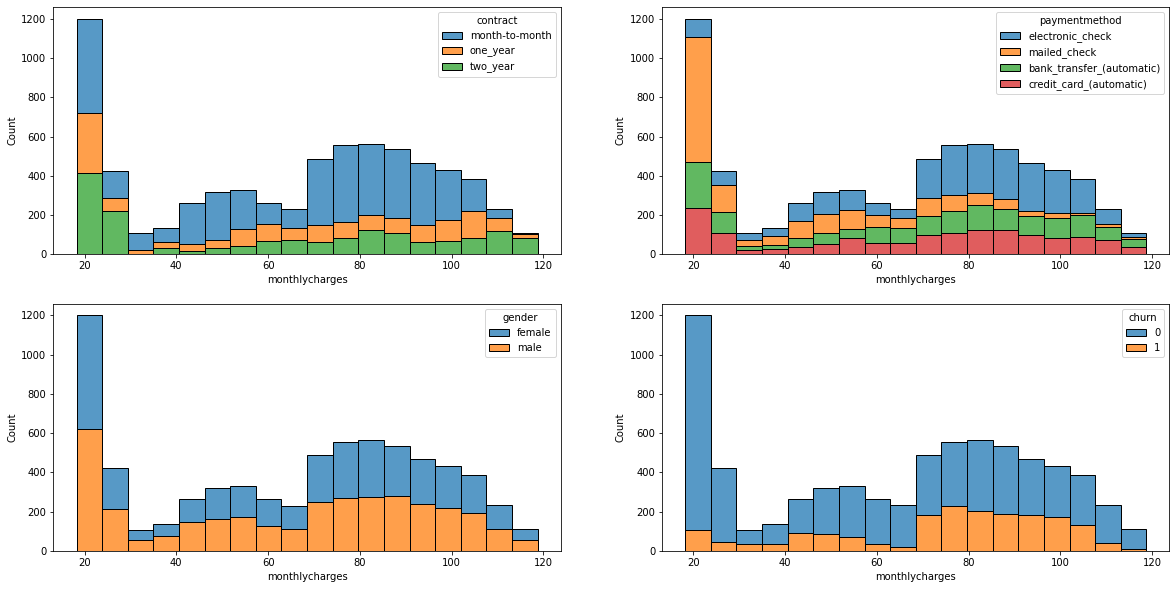

In [41]:
categorical = ['contract', 'paymentmethod', 'gender', 'churn']

fig, axs = plt.subplots(2, 2, figsize=(20,10))

for variable, ax in zip(categorical, axs.flatten()):
  sns.histplot(df, x='monthlycharges', hue=variable, multiple='stack', ax=ax)

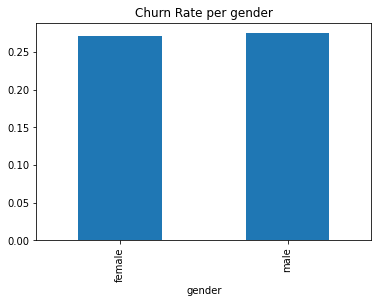

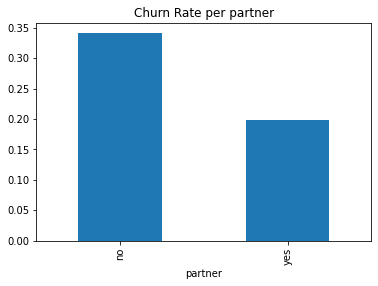

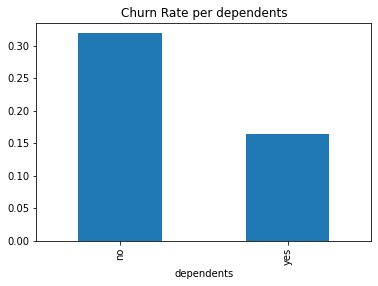

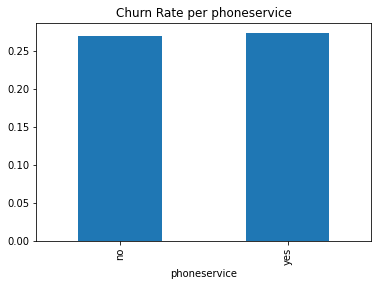

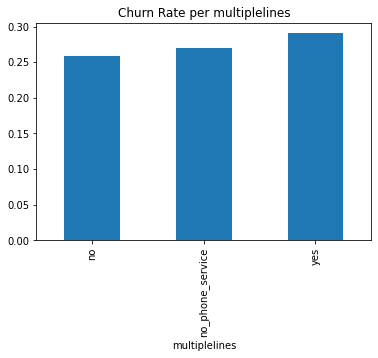

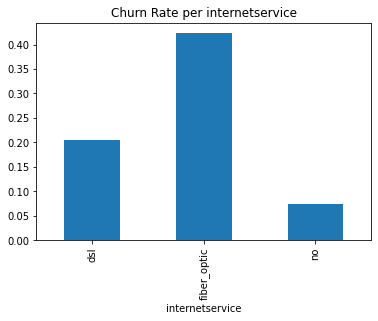

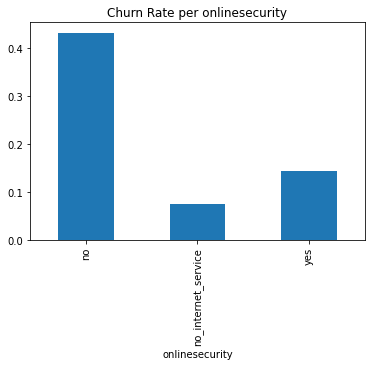

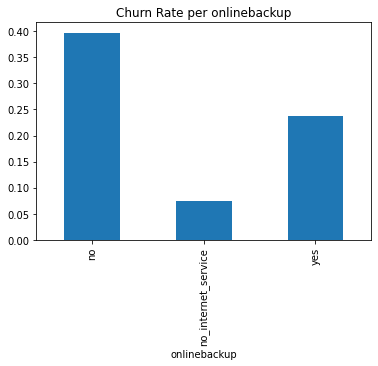

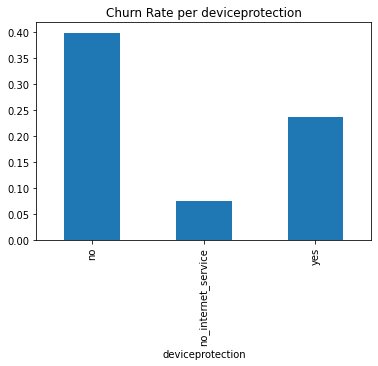

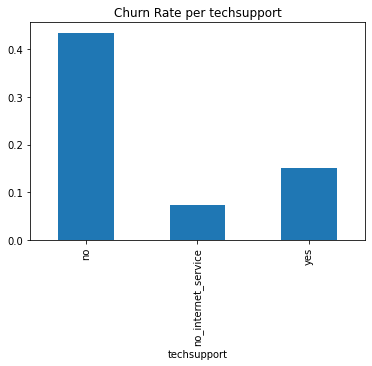

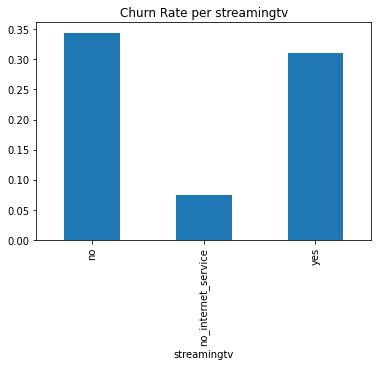

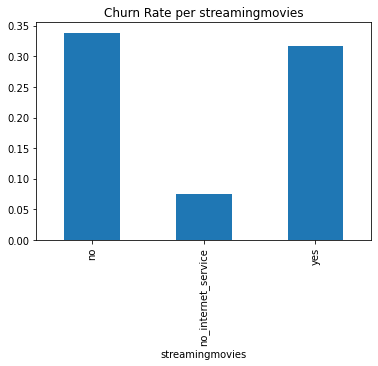

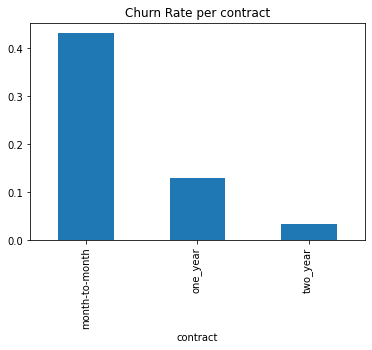

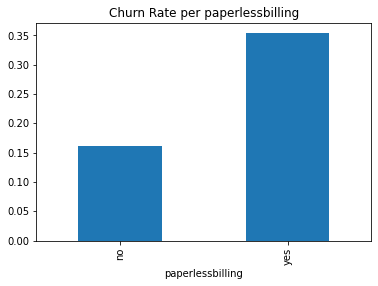

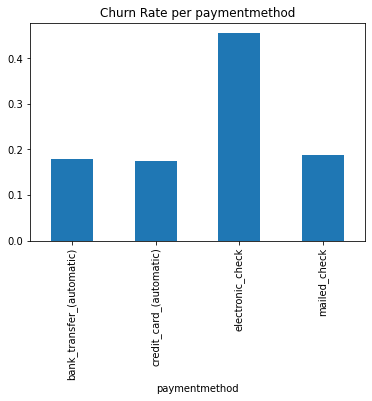

In [95]:
for category in categorical:
  df_train.groupby(category)['churn'].mean().plot(kind='bar')
  plt.title('Churn Rate per ' + str(category))
  plt.show()

### Feature Importance

##### Mututal Information

In [97]:
def mutual_info_score_churn(series):
  return mutual_info_score(series, df_train['churn'])

In [158]:
df_train[categorical].apply(mutual_info_score_churn).sort_values(ascending=False)

contract            0.093212
onlinesecurity      0.069888
techsupport         0.069441
internetservice     0.054798
deviceprotection    0.045083
onlinebackup        0.044512
paymentmethod       0.041142
streamingtv         0.033757
streamingmovies     0.033471
paperlessbilling    0.023813
dependents          0.013336
partner             0.012800
multiplelines       0.000582
gender              0.000009
phoneservice        0.000003
dtype: float64

##### Correlation

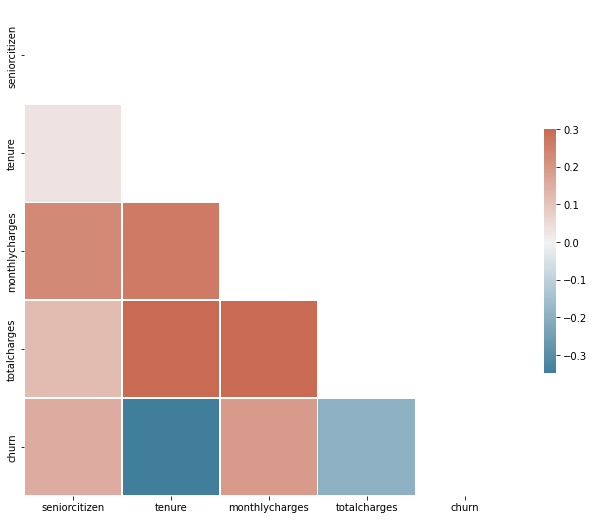

In [106]:
# Compute the correlation matrix
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Modelling

In [159]:
x = df_train[categorical].apply(mutual_info_score_churn).sort_values(ascending=False)
filter = x > 0.04
list(filter[filter == True].index)

['contract',
 'onlinesecurity',
 'techsupport',
 'internetservice',
 'deviceprotection',
 'onlinebackup',
 'paymentmethod']

In [169]:
#Features
categorical = list(filter[filter == True].index)
numeric = list(df_train.dtypes[df.dtypes != "object"].index)
numeric.remove('churn')


target = 'churn'
features = numeric + categorical

In [171]:
X_train, X_validate, X_test = df_train[features], df_validate[features], df_test[features]

In [173]:
y_train, y_validate, y_test = df_train[target], df_validate[target], df_test[target]

In [174]:
print([len(X_train), len(y_train)])
print([len(X_validate), len(y_validate)])
print([len(X_test), len(y_test)])

[4225, 4225]
[1409, 1409]
[1409, 1409]


In [175]:
X_train.head()

,seniorcitizen,tenure,monthlycharges,totalcharges,contract,onlinesecurity,techsupport,internetservice,deviceprotection,onlinebackup,paymentmethod
0,0,19,58.20,1045.25,one_year,no,no,dsl,no,yes,electronic_check
1,0,60,116.60,7049.50,one_year,yes,yes,fiber_optic,yes,yes,credit_card_(automatic)
2,0,13,71.95,923.85,month-to-month,yes,no,dsl,no,no,electronic_check
3,0,1,20.45,20.45,two_year,no_internet_service,no_internet_service,no,no_internet_service,no_internet_service,mailed_check
4,0,55,77.75,4266.40,month-to-month,no,no,fiber_optic,no,yes,credit_card_(automatic)


In [176]:
X_train.columns

Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges', 'contract',
       'onlinesecurity', 'techsupport', 'internetservice', 'deviceprotection',
       'onlinebackup', 'paymentmethod'],
      dtype='object')

#### Pipeline

In [178]:
onehot_encoder = OneHotEncoder(drop_last_binary=True)

In [181]:
reg = LogisticRegression(random_state=0)

In [182]:
model_pipeline = make_pipeline(
    onehot_encoder,
    reg
)

In [183]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop_last_binary=True)),
                ('logisticregression', LogisticRegression(random_state=0))])

In [184]:
y_pred = model_pipeline.predict(X_train)

In [188]:
#Metrics

#Precision = (True Positive + True Negative)/(All Predictions), i.e. 'Qual o % de acerto nas predições?'
acc = accuracy_score(y_train, y_pred)

#Precision = True Positive/(True Positive + False Positive), i.e. 'De todas as predições positivas, qual % corresponde às positivas corretas'
prc = precision_score(y_train, y_pred)

#Recall = True Positive/(True Positive + False Negatives), i.e. ''
rec = recall_score(y_train, y_pred)


print('Accuracy classification score: ' + str(round(acc, 4)))
print('Precision classification score: ' + str(round(prc, 4)))
print('Recall classification score: ' + str(round(rec, 4)))

Accuracy classification score: 0.7957
Precision classification score: 0.6539
Recall classification score: 0.5343
